In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import networkx as nx

In [2]:
import heapq

In [3]:
from create_graph.create_graph import generate_distances
NUM_SHOWERS_IN_BRICK = 150

In [4]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output
import sys
sys.path.append("..")
from tools.opera_tools import plot_graphx, DISTANCE, scattering_estimation_loss
from sklearn.linear_model import TheilSenRegressor
from copy import deepcopy      
from collections import Counter

process = psutil.Process(os.getpid())

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.5 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [5]:
from functools import total_ordering

@total_ordering
class ClusterHDBSCAN(object):
    def __init__(self, weight: float, cl_size: int, clusters: list = None, nodes: list = None):
        # init
        self.nodes = set()
        self.nodes_in = Counter()
        self.nodes_out = Counter()
        
        self.weights_nodes_dict = defaultdict(set)
        
        self.weight_death = weight
        self.lambda_death = 1. / (weight + 1e-5)
        
        self.weight_birth = weight
        self.lambda_birth = 1. / (weight + 1e-5)
        
        
        self.children = []
        self.falling_out_points = []
        
        assert clusters is not None or nodes is not None
        if clusters is not None:
            for cluster in clusters:
                self.nodes.update(cluster.nodes)
                self.nodes_in.update(cluster.nodes_in)
                self.nodes_out.update(cluster.nodes_out)
                self.weights_nodes_dict[weight].update(cluster.nodes)
                if cluster.is_cluster:
                    cluster.set_weight_birth(weight)
                    self.children.append(cluster)
                else:
                    self.falling_out_points.append(cluster)
        else:
            self.nodes.update(nodes)
            self.nodes_out.update(nodes)
            self.weights_nodes_dict[weight].update(nodes)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.cl_size = cl_size
        self.is_cluster = len(self) >= cl_size
        self.is_noise = not self.is_cluster
        self.stability = None
        
        
    def append(self, weight: float, clusters: list):
        """
        Adding
        """
        for cluster in clusters:
            self.nodes.update(cluster.nodes)
            self.weights_nodes_dict[weight].update(cluster.nodes)
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.is_cluster = len(self) >= self.cl_size
        self.is_noise = not self.is_cluster
        return self
    
    def __iter__(self):
        for child in self.children:
            yield child
    
    def __contains__(self, node):
        return node in self.nodes
    
    def __len__(self):
        return len(self.nodes)
    
    def __hash__(self):
        return self.__hash
    
    def __eq__(self, other):
        return self.__hash == other.__hash

    def __lt__(self, other):
        return self.__hash < other.__hash
    
    def set_weight_birth(self, weight: float):
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        
    def calculate_stability(self):
        self.stability = 0.
        self.lambda_birth = 1 / (max(self.weights_nodes_dict.keys()) + 1e-5)
        norm = self.lambda_birth
        for weight in self.weights_nodes_dict:
            self.stability += len(self.weights_nodes_dict[weight]) * (1 / (weight + 1e-5) - self.lambda_birth) * norm
            
def calc_stabilities(root):
    root.calculate_stability()
    for child in root:
        calc_stabilities(child)
        
        
def class_disbalance(cluster, graph):
    subgraph = graph.subgraph(cluster.nodes)
    signal = []
    for _, node in subgraph.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def flat_clusters(root):
    if root.is_cluster:
        yield root
        
    for child in root:
        for cluster in flat_clusters(child):
            yield cluster
            
def reed_stabilities(root, level=0):
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)), end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        reed_stabilities(child, level + 1)

def print_class_disbalance_for_all_clusters(root, graph, level=0):
    class_disbalance_tuples = class_disbalance(root, graph)

    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples, end=' ')
    print('stability={:.3f}'.format(root.stability))
    for child in root:
        print_class_disbalance_for_all_clusters(child, graph, level + 1)
        
def leaf_clusters(root):
    if root.is_cluster and len(root.children) == 0:
        yield root
        
    for child in root:
        for cluster in leaf_clusters(child):
            yield cluster

def max_level_clusters(root, level=0, max_level=2):
    if level == max_level and root.is_cluster:
        yield root
        
    for child in root:
        for cluster in max_level_clusters(child, level=level+1, max_level=max_level):
            yield cluster
            
            
def recalc_tree(root):
    weights_children = 0
    for child in root:
        weights_children += recalc_tree(child)
    if weights_children > root.stability:
        root.stability = weights_children
    else:
        root.children.clear()
    
    return root.stability


In [6]:
from math import fabs, sqrt, log
def rms_integral_root_closed_py(basetrack_left, basetrack_right):
    EPS = 1e-6
    dz = basetrack_right['features']['SZ'] - basetrack_left['features']['SZ']
    dx = basetrack_left['features']['SX'] - (basetrack_right['features']['SX'] - basetrack_right['features']['TX'] * dz)
    dy = basetrack_left['features']['SY'] - (basetrack_right['features']['SY'] - basetrack_right['features']['TY'] * dz)
    dtx = (basetrack_left['features']['TX'] - basetrack_right['features']['TX'])
    dty = (basetrack_left['features']['TY'] - basetrack_right['features']['TY'])
    
    a = (dtx * dz) ** 2 + (dty * dz) ** 2
    b = 2 * (dtx * dz * dx +  dty * dz * dy)
    c = dx ** 2 + dy ** 2
    if a == 0.:
        return fabs(sqrt(c))
    discriminant = (b ** 2 - 4 * a * c)
    log_denominator = 2 * sqrt(a) * sqrt(a + b + c) + 2 * a + b + EPS
    log_numerator = 2 * sqrt(a) * sqrt(c) + b + EPS
    first_part = ( (2 * a + b) * sqrt(a + b + c) - b * sqrt(c) ) / (4 * a)
    
    if fabs(discriminant) < EPS:
        return fabs(first_part)
    else: 
        result = fabs((discriminant * log(log_numerator / log_denominator) / (8 * sqrt(a * a * a)) + first_part))
        return result


def class_disbalance_graphx(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def class_disbalance_graphx__(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return np.unique(signal, return_counts=True)

In [7]:
from math import sqrt
from sklearn.linear_model import TheilSenRegressor, LinearRegression, HuberRegressor

def estimate_params(cluster, angle=0.03):
    x, y, z = estimate_start_xyz(cluster)
    tx, ty = estimate_txty(cluster)
    n = 0
    for i, node in cluster.nodes(data=True):
        #print(x, node['features']['SX'])
        dx = node['features']['SX'] - x
        dy = node['features']['SY'] - y
        dz = node['features']['SZ'] - z 
        dx = dx / dz - tx
        dy = dy / dz - ty
        dz = dz / dz
        if sqrt(dx**2 + dy**2) < angle:
            n += 1
            
    return n / len(cluster), x, y, z, tx, ty


def estimate_start_xyz(cluster, k=3, shift_x=0., shift_y=0., shift_z=-2000.):
    xs = []
    ys = []
    zs = []

    for i, node in cluster.nodes(data=True):
        xs.append(node['features']['SX'])
        ys.append(node['features']['SY'])
        zs.append(node['features']['SZ'])
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    
    argosorted_z = np.argsort(zs)
    
    x = np.median(np.median(xs[argosorted_z][:k])) + shift_x
    y = np.median(np.median(ys[argosorted_z][:k])) + shift_y
    z = np.median(np.median(zs[argosorted_z][:k])) + shift_z
    
    return x, y, z

def estimate_txty(cluster, k=20):
    xs = []
    ys = []
    zs = []
    tx = []
    ty = []

    for i, node in cluster.nodes(data=True):
        xs.append(node['features']['SX'])
        ys.append(node['features']['SY'])
        zs.append(node['features']['SZ'])
        tx.append(node['features']['TX'])
        ty.append(node['features']['TY'])
        
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    tx = np.array(tx)
    ty = np.array(ty)
    
    
    argosorted_z = np.argsort(zs)
    lr = TheilSenRegressor()
    lr.fit(zs[argosorted_z][:k].reshape((-1, 1)), xs[argosorted_z][:k])
    TX = lr.coef_[0]

    lr.fit(zs[argosorted_z][:k].reshape((-1, 1)), ys[argosorted_z][:k])
    TY = lr.coef_[0]
    
    return TX, TY
    return np.median(np.median(tx[argosorted_z][:k])), np.median(np.median(ty[argosorted_z][:k]))

## Load data

In [8]:
from tools.opera_tools import combine_mc_bg, gen_graphx, gen_x_y_dataset, load_bg, load_mc
pmc = load_mc(filename='../data/mcdata_taue2.root', step=1)
def pmc_to_ship_format(pmc):
    showers = []
    scale = 10000
    for idx in pmc.index:
        shower = pmc.loc[idx]
        
        showers.append(
            {
                'TX': shower['BT_X'] / scale,
                'TY': shower['BT_Y'] / scale,
                'TZ': shower['BT_Z'] / scale,
                'PX': shower['BT_SX'],
                'PY': shower['BT_SY'],
                'PZ': np.ones_like(shower['BT_X']),
                'ele_P': shower['ele_P'],
                'ele_TX': shower['ele_x'] / scale,
                'ele_TY': shower['ele_y'] / scale,
                'ele_TZ': shower['ele_z']  / scale,
                'ele_PX': shower['ele_sx'],
                'ele_PY': shower['ele_sy'],
                'ele_PZ': 1.
            }
        )
    return showers
selected_showers = pmc_to_ship_format(pmc)


numtracks reduction by cuts:  [18724, 18679, 9616, 9106]
len(pmc): 9106


In [9]:
selected_showers = [selected_shower for selected_shower in selected_showers if len(selected_shower['PX']) > 70]

In [10]:
selected_showers = [selected_shower for selected_shower in selected_showers if len(selected_shower['PX']) < 3000]

In [11]:
len(selected_showers)

8019

In [12]:
bricks = []

In [13]:
%%time
scale = 10000
bricks = []
for i in range(len(selected_showers) // NUM_SHOWERS_IN_BRICK):
    node_id = 0
    graphx = nx.DiGraph()
    nodes_to_add = []
    showers_data = []
    for j in range(NUM_SHOWERS_IN_BRICK):
        selected_shower = selected_showers[i * NUM_SHOWERS_IN_BRICK + j]
        showers_data.append(
            {
            'numtracks': len(selected_shower['PX']),
            'signal': j,
            'ele_P': selected_shower['ele_P'],
            'ele_SX': selected_shower['ele_TX'] * scale,
            'ele_SY': selected_shower['ele_TY'] * scale,
            'ele_SZ': selected_shower['ele_TZ'] * scale,
            'ele_TX': selected_shower['ele_PX'] / selected_shower['ele_PZ'],
            'ele_TY': selected_shower['ele_PY'] / selected_shower['ele_PZ']
            }
        )
        for k in range(len(selected_shower['PX'])):
            nodes_to_add.append(
                (
                    node_id,
                    {
                        'features': {
                            'SX': selected_shower['TX'][k] * scale,
                            'SY': selected_shower['TY'][k] * scale,
                            'SZ': selected_shower['TZ'][k] * scale,
                            'TX': selected_shower['PX'][k] / selected_shower['PZ'][k],
                            'TY': selected_shower['PY'][k] / selected_shower['PZ'][k],
                        },
                        'signal': j
                    }
                )
            )
            node_id += 1
    graphx.add_nodes_from(nodes_to_add)
    graphx.graph['showers_data'] = showers_data
    bricks.append(graphx)

CPU times: user 1min 30s, sys: 8.07 s, total: 1min 38s
Wall time: 1min 39s


In [14]:
len(bricks)

53

## Функция подсчёта метрики

In [15]:
import itertools
from operator import itemgetter
def k_nearest_cut_succ(graphx, k):
    for node_id in tqdm(graphx.nodes()):
        successors = list(graphx.successors(node_id))
        if len(successors) <= k:
            continue
        edges = list(itertools.product([node_id], successors))
        weights = []
        for edge in edges:
            weights.append(graphx[edge[0]][edge[1]]['weight'])
        weights, edges = [list(x) for x in zip(*sorted(zip(weights, edges), key=itemgetter(0)))]
        edges_to_remove = edges[k:]
        if len(edges_to_remove):
            graphx.remove_edges_from(edges_to_remove)
    return graphx

def k_nearest_cut_pred(graphx, k):
    for node_id in tqdm(graphx.nodes()):
        predecessors = list(graphx.predecessors(node_id))
        if len(predecessors) <= k:
            continue
        edges = list(itertools.product(predecessors, [node_id]))
        weights = []
        for edge in edges:
            weights.append(graphx[edge[0]][edge[1]]['weight'])
        weights, edges = [list(x) for x in zip(*sorted(zip(weights, edges), key=itemgetter(0)))]

        edges_to_remove = edges[k:]
        if len(edges_to_remove):
            graphx.remove_edges_from(edges_to_remove)
    return graphx

In [16]:
import operator
from collections import Counter

def run_hdbscan(G, cl_size=20, order=True):
    ####### core_d was deleted => could be returned. Laverage robustness / cluster shaprness.
    edges = []
    for node_id_left, node_id_right, edge in G.edges(data=True):
        node_left = G.node[node_id_left]
        node_right = G.node[node_id_right]
        edges.append(
            (
            node_id_left, node_id_right, edge['weight'], np.sign(node_left['features']['SZ'] - node_right['features']['SZ'])
            )
        )

    #nx.mini
    #edges = list(G.edges(data=True))
    #edges = [(edge[0], # 0
    #          edge[1], # 1
    #          edge[2]['weight'], # 2
    #         ) for edge in edges]
    
    edges = sorted(edges, key = operator.itemgetter(2))

    ### Minimum spanning tree was also thrown
    ### following algo reminds of Kruskal algo but with some modifications

    ### TODO: sort on some mix(i.e. linear) of Z_coord and integrated distance
    
    # init
    clusters = {}
    for node_id in G.nodes():
        clusters[node_id]=ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id])


    for i, j, weight, *_ in edges:
        cluster_out = clusters[i]
        cluster_in = clusters[j]

        ### tunable parameter
        #if cluster_in.nodes_in[j] > 1:
        #    continue

        if cluster_in is cluster_out:
            continue

        if cluster_in.is_cluster and cluster_out.is_cluster:
            cluster = ClusterHDBSCAN(weight=weight , cl_size=cl_size, clusters=[cluster_in, cluster_out])
        elif cluster_in.is_cluster and not cluster_out.is_cluster:
            cluster = cluster_in.append(weight=weight, clusters=[cluster_out])
        elif cluster_out.is_cluster and not cluster_in.is_cluster:
            cluster = cluster_out.append(weight=weight, clusters=[cluster_in])
        else:
            cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=[cluster_in, cluster_out])

        cluster.nodes_out[i] += 1
        cluster.nodes_in[j] += 1

        clusters.update({l: cluster for l in cluster.nodes})
        
    clusters = list(set(clusters.values()))

    ### choose biggest cluster
    root = clusters[0]
    length = len(clusters[0])
    for cluster in clusters:
        if len(cluster) > length:
            length = len(cluster)
            root = cluster
    
    calc_stabilities(root)
    #recalc_tree(root)
    clusters = list(leaf_clusters(root))
    return clusters, root

In [17]:
def run_hdbscan_on_brick(graphx, min_cl=40, cl_size=40, order=True):
    connected_components = []
    for cnn in nx.connected_components(nx.Graph(graphx)):
        if len(cnn) > min_cl:
            connected_components.append(nx.DiGraph(graphx.subgraph(cnn)))
    clusters = []
    roots = []
    for G in connected_components:
        if len(G) < 100:
            clusters.append(G)
        else:
            clusters_hdbscan, root_hdbscan = run_hdbscan(G, cl_size=cl_size, order=order)
            roots.append(root_hdbscan)
            clusters.extend(clusters_hdbscan)
    
    return graphx, clusters, roots

In [18]:
def run_gen_graphx(graphx, layers=2, threshold=250):
    graphx_nodes = list(graphx.nodes(data=True))
    edges = list(graphx.edges())
    graphx.remove_edges_from(edges)
    ebunch = generate_distances(graphx_nodes, layers=layers, threshold=threshold)
    graphx.add_edges_from(ebunch)
    return graphx

In [19]:
def estimate_e(cluster, angle=0.005):
    x, y, z = estimate_start_xyz(cluster)
    tx, ty = estimate_txty(cluster)
    n = 0
    for i, node in cluster.nodes(data=True):
        dx = node['features']['SX'] - x
        dy = node['features']['SY'] - y
        dz = node['features']['SZ'] - z 
        dx = dx / dz - tx
        dy = dy / dz - ty
        dz = dz / dz
        if sqrt(dx**2 + dy**2) < angle:
            n += 1
            
    return n / len(cluster)

In [20]:
def return_train_data(root, graphx):
    for child in root:
        for Xy in return_train_data(child, graphx):
            yield Xy
    if root.is_cluster and root.children:
        yield get_train_data(root, graphx)
        
def get_cluster_params(root, graphx):
    graphx_root = graphx.subgraph(root.nodes)
    _, x, y, z, tx, ty = estimate_params(graphx_root)
    return x, y, z, tx, ty


def all_clusters_params(root, graphx):
    for child in root:
        for x, y, z, tx, ty in all_clusters_params(child, graphx):
            yield x, y, z, tx, ty
    if root.is_cluster:
        yield get_cluster_params(root, graphx)
        
        
def estimate_params(cluster):
    x, y, z = estimate_start_xyz(cluster)
    tx, ty = estimate_txty(cluster)
    return x, y, z, tx, ty

def get_train_data(root, graphx):
    graphx_root = graphx.subgraph(root.nodes)
    children = [graphx.subgraph(root.children[0].nodes), 
                graphx.subgraph(root.children[1].nodes)]
    x_r, y_r, z_r, tx_r, ty_r = estimate_params(graphx_root)
    x_c1, y_c1, z_c1, tx_c1, ty_c1 = estimate_params(children[0])
    x_c2, y_c2, z_c2, tx_c2, ty_c2 = estimate_params(children[1])
    X = [
            estimate_e(graphx_root, angle=0.01), 
            estimate_e(graphx_root, angle=0.03), 
            estimate_e(graphx_root, angle=0.05),
            estimate_e(children[0], angle=0.01),
            estimate_e(children[0], angle=0.03),
            estimate_e(children[1], angle=0.01),
            estimate_e(children[1], angle=0.03),
            sqrt((tx_r - tx_c1)**2 + (ty_r - ty_c1)**2),
            sqrt((tx_r - tx_c2)**2 + (ty_r - ty_c2)**2),
            root.lambda_birth, 
            root.stability, 
            root.children[0].stability, 
            root.children[1].stability
        ]
    cl_dis = np.array(list(zip(*class_disbalance_graphx(graphx_root)))[1])
    if len(cl_dis) == 1:
        y = 1
    elif (cl_dis / cl_dis.sum()).max() > 0.9 and cl_dis.min() < 40:
        y = 1
    else:
        y = 0
    return X, y

def return_train_data(root, graphx):
    for child in root:
        for Xy in return_train_data(child, graphx):
            yield Xy
    if root.is_cluster and root.children:
        Xy = get_train_data(root, graphx)
        root.Xy = Xy
        yield Xy

In [21]:
from IPython.display import clear_output
X = []
y = []
group = []
clusterized_bricks = []
g = 0
for graphx in tqdm(bricks[:len(bricks) // 4]):
    print(len(X))
    run_gen_graphx(graphx, layers=5, threshold=400)
    k_nearest_cut_succ(graphx, 25)
    k_nearest_cut_pred(graphx, 25)
    graphx, clusters, roots = run_hdbscan_on_brick(graphx=graphx, min_cl=40, cl_size=40)
    for root in roots:
        try:
            X_tmp, y_tmp = list(zip(*list(return_train_data(root, graphx.subgraph(root.nodes)))))
            X.append(np.array(X_tmp))
            y.append(np.array(y_tmp))
            group.append(np.full_like(a=y_tmp, fill_value=g))
            g += 1
        except:
            pass
    clear_output()

 77%|███████▋  | 10/13 [2:46:24<49:55, 998.48s/it] 

410



  3%|▎         | 3094/88563 [00:33<15:37, 91.12it/s]


  6%|▌         | 5111/88563 [01:09<18:57, 73.35it/s]


  6%|▌         | 5203/88563 [01:11<18:59, 73.17it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 16%|█▌        | 13764/88563 [03:25<18:37, 66.95it/s]


 18%|█▊        | 16221/88563 [04:00<17:51, 67.53it/s]


 21%|██        | 18320/88563 [04:36<17:39, 66.27it/s]


 22%|██▏       | 19877/88563 [04:55<16:59, 67.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 36%|███▌      | 31576/88563 [07:01<12:40, 74.93it/s]


 39%|███▉      | 34918/88563 [07:34<11:37, 76.88it/s]


 43%|████▎     | 38253/88563 [08:07<10:40, 78.49it/s]


 47%|████▋     | 41473/88563 [08:40<09:51, 79.66it/s]


 50%|█████     | 44419/88563 [09:09<09:05, 80.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 61%|██████    | 53596/88563 [10:50<07:04, 82.36it/s]


 64%|██████▍   | 56962/88563 [11:23<06:19, 83.34it/s]


 68%|██████▊   | 60362/88563 [11:56<05:34, 84.20it/s]


 72%|███████▏  | 63874/88563 [12:30<04:49, 85.15it/s]


 73%|███████▎  | 65091/88563 [12:42<04:34, 85.37it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 87%|████████▋ | 76962/88563 [14:55<02:14, 85.98it/s]


 90%|█████████ | 79886/88563 [15:27<01:40, 86.11it/s]


 93%|█████████▎| 82669/88563 [16:00<01:08, 86.09it/s]


 96%|█████████▋| 85316/88563 [16:29<00:37, 86.23it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


  5%|▌         | 4365/84196 [00:43<13:16, 100.23it/s]


  9%|▉         | 7722/84196 [01:16<12:38, 100.88it/s]


 13%|█▎        | 11316/84196 [01:49<11:43, 103.63it/s]


 17%|█▋        | 14185/84196 [02:21<11:38, 100.19it/s]


 18%|█▊        | 15449/84196 [02:35<11:32, 99.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 31%|███▏      | 26320/84196 [04:44<10:25, 92.49it/s]


 35%|███▌      | 29489/84196 [05:17<09:48, 92.98it/s]


 39%|███▉      | 32902/84196 [05:49<09:05, 94.03it/s]


 43%|████▎     | 36268/84196 [06:20<08:23, 95.24it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 55%|█████▌    | 46667/84196 [08:00<06:26, 97.19it/s]


 59%|█████▉    | 50011/84196 [08:32<05:50, 97.50it/s]


 63%|██████▎   | 53423/84196 [09:05<05:14, 97.97it/s]


 67%|██████▋   | 56442/84196 [09:38<04:44, 97.64it/s]


 69%|██████▉   | 57911/84196 [09:53<04:29, 97.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 82%|████████▏ | 68988/84196 [11:55<02:37, 96.46it/s]


 86%|████████▌ | 72297/84196 [12:27<02:03, 96.69it/s]


 90%|████████▉ | 75583/84196 [13:00<01:28, 96.84it/s]


 93%|█████████▎| 78665/84196 [13:32<00:57, 96.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


  2%|▏         | 2052/83771 [00:21<14:04, 96.74it/s]


  7%|▋         | 5593/83771 [00:53<12:34, 103.66it/s]


 11%|█         | 8907/83771 [01:26<12:08, 102.71it/s]


 14%|█▍        | 11953/83771 [02:00<12:02, 99.44it/s]


 16%|█▌        | 13565/83771 [02:16<11:45, 99.48it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 31%|███       | 26082/83771 [04:29<09:55, 96.82it/s]


 35%|███▌      | 29655/83771 [05:02<09:11, 98.04it/s]


 40%|███▉      | 33221/83771 [05:35<08:30, 99.06it/s]


 42%|████▏     | 34944/83771 [05:51<08:11, 99.29it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 58%|█████▊    | 48699/83771 [08:01<05:46, 101.13it/s]


 62%|██████▏   | 51727/83771 [08:34<05:18, 100.62it/s]


 65%|██████▌   | 54733/83771 [09:08<04:51, 99.79it/s]


 67%|██████▋   | 56505/83771 [09:25<04:33, 99.87it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 80%|███████▉  | 66905/83771 [11:16<02:50, 98.97it/s]


 84%|████████▎ | 70081/83771 [12:01<02:20, 97.15it/s]


 87%|████████▋ | 73027/83771 [12:34<01:51, 96.79it/s]


 91%|█████████▏| 76454/83771 [13:08<01:15, 97.02it/s]


 91%|█████████▏| 76577/83771 [13:09<01:14, 96.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
X = np.concatenate(X)
X = np.c_[X, X[:, -1] + X[:, -2] - X[:, -3]]
y = np.concatenate(y)
group = np.concatenate(group)

In [24]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1026,  619]))

In [25]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(C=100, gamma=0.1, probability=True)
clf = GridSearchCV(svc, {}, scoring='roc_auc')
clf.fit(X, y, group)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [26]:
clf.grid_scores_

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.97166, std: 0.00118, params: {}]

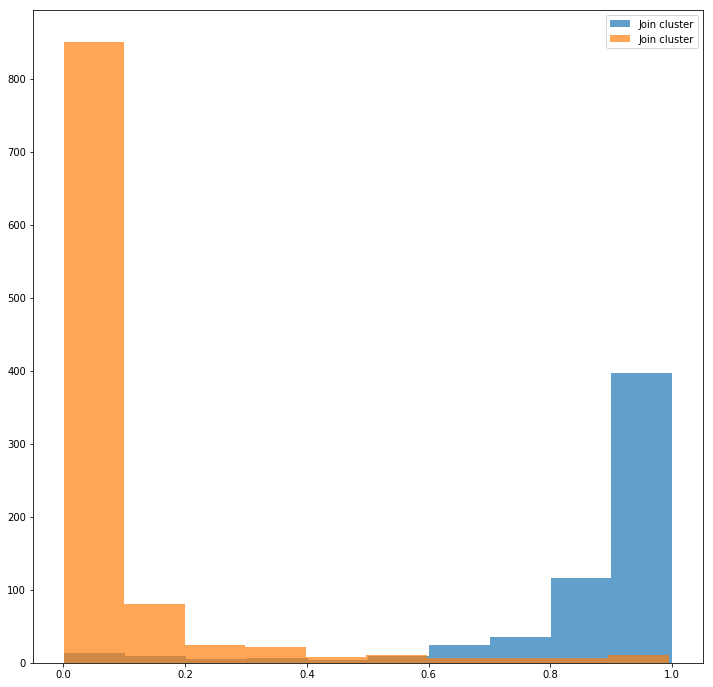

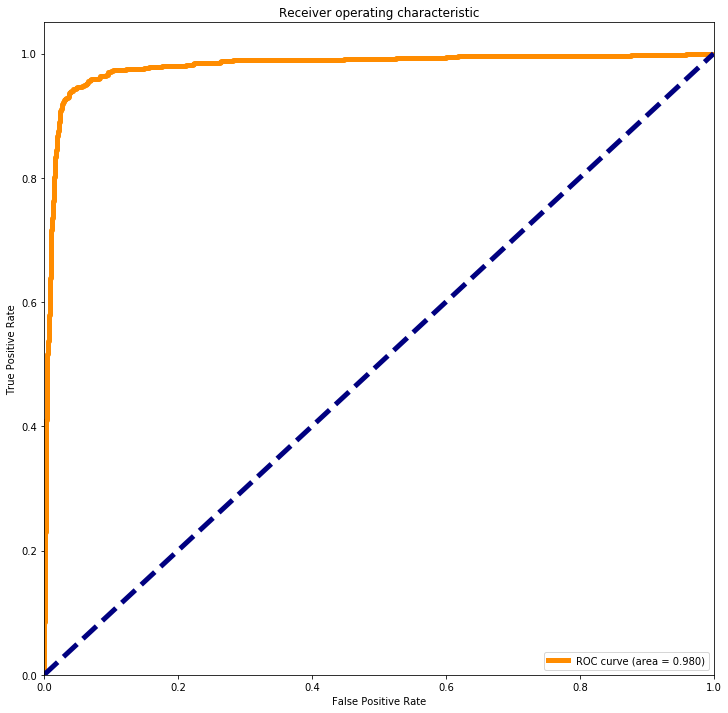

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score

plt.figure(figsize=(12, 12))
predictions = clf.predict_proba(X)[:, 1]
plt.hist(predictions[y==1], label='Join cluster', alpha=0.7)
plt.hist(predictions[y==0], label='Divide cluster', alpha=0.7)
plt.legend()
plt.show()


fpr, tpr, _ = roc_curve(y, predictions)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(12, 12))
lw = 5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
import operator
from collections import Counter
def make_it_trained(root, graphx):
    print('done')
    for child in root:
        make_it_trained(child, graphx)
    if root.is_cluster and root.children:
        Xy = get_train_data(root, graphx)
        X = Xy[0]
        X.append(X[-1] + X[-2] - X[-3])
        root.X = X
        
def run_hdbscan_clf(G, clf, cl_size=20, order=True):
    ####### core_d was deleted => could be returned. Laverage robustness / cluster shaprness.
    edges = []
    for node_id_left, node_id_right, edge in G.edges(data=True):
        node_left = G.node[node_id_left]
        node_right = G.node[node_id_right]
        edges.append(
            (
            node_id_left, node_id_right, edge['weight'], np.sign(node_left['features']['SZ'] - node_right['features']['SZ'])
            )
        )

    #nx.mini
    #edges = list(G.edges(data=True))
    #edges = [(edge[0], # 0
    #          edge[1], # 1
    #          edge[2]['weight'], # 2
    #         ) for edge in edges]
    
    edges = sorted(edges, key = operator.itemgetter(2))

    ### Minimum spanning tree was also thrown
    ### following algo reminds of Kruskal algo but with some modifications

    ### TODO: sort on some mix(i.e. linear) of Z_coord and integrated distance
    
    # init
    clusters = {}
    for node_id in G.nodes():
        clusters[node_id]=ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id])


    for i, j, weight, *_ in edges:
        cluster_out = clusters[i]
        cluster_in = clusters[j]

        ### tunable parameter
        #if cluster_in.nodes_in[j] > 1:
        #    continue

        if cluster_in is cluster_out:
            continue

        if cluster_in.is_cluster and cluster_out.is_cluster:
            cluster = ClusterHDBSCAN(weight=weight , cl_size=cl_size, clusters=[cluster_in, cluster_out])
        elif cluster_in.is_cluster and not cluster_out.is_cluster:
            cluster = cluster_in.append(weight=weight, clusters=[cluster_out])
        elif cluster_out.is_cluster and not cluster_in.is_cluster:
            cluster = cluster_out.append(weight=weight, clusters=[cluster_in])
        else:
            cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=[cluster_in, cluster_out])

        cluster.nodes_out[i] += 1
        cluster.nodes_in[j] += 1

        clusters.update({l: cluster for l in cluster.nodes})
        
    clusters = list(set(clusters.values()))

    ### choose biggest cluster
    root = clusters[0]
    length = len(clusters[0])
    for cluster in clusters:
        if len(cluster) > length:
            length = len(cluster)
            root = cluster
    
    calc_stabilities(root)
    make_it_trained(root, G.subgraph(root.nodes))
    recalc_tree_clf(root, clf)
    clusters = list(leaf_clusters(root))
    return clusters, root

TH = 0.8

def recalc_tree_clf(root, clf):
    weights_children = 0
    #try:
    if root.children and root.is_cluster:
        p = clf.predict_proba([root.X])[0][1]
    else:
        p = 1.
    for child in root:
        recalc_tree_clf(child, clf)
    if p > TH:
        root.children.clear()
    return root

def run_hdbscan_on_brick_clf(graphx, clf, min_cl=40, cl_size=40, order=True):
    connected_components = []
    for cnn in nx.connected_components(nx.Graph(graphx)):
        if len(cnn) > min_cl:
            connected_components.append(nx.DiGraph(graphx.subgraph(cnn)))
    clusters = []
    roots = []
    for G in connected_components:
        if len(G) < 100:
            clusters.append(G)
        else:
            clusters_hdbscan, root_hdbscan = run_hdbscan_clf(G, clf, cl_size=cl_size, order=order)
            roots.append(root_hdbscan)
            clusters.extend(clusters_hdbscan)
    clusters_graphx = []
    for cluster in clusters:
        clusters_graphx.append(
            nx.DiGraph(graphx.subgraph(cluster.nodes))
        )
    return graphx, clusters, roots, clusters_graphx

In [ ]:
TH = 0.8

from IPython.display import clear_output
clusterized_bricks = []
for graphx in tqdm(bricks[len(bricks) // 4:]):
    run_gen_graphx(graphx, layers=5, threshold=400)
    k_nearest_cut_succ(graphx, 25)
    k_nearest_cut_pred(graphx, 25)
    graphx, clusters, roots, clusters_graphx = run_hdbscan_on_brick_clf(graphx=graphx, clf=clf, min_cl=40, cl_size=40)
    clusterized_bricks.append(
        {
            'graphx': graphx,
            'clusters': clusters_graphx,
        }
    )
    clear_output()


 50%|█████     | 20/40 [6:40:28<6:40:28, 1201.43s/it]

  0%|          | 0/77178 [00:00<?, ?it/s]

  0%|          | 24/77178 [00:00<05:32, 232.19it/s]

  0%|          | 37/77178 [00:00<07:12, 178.48it/s]

  0%|          | 46/77178 [00:00<08:56, 143.84it/s]

  0%|          | 63/77178 [00:00<08:35, 149.62it/s]

  0%|          | 82/77178 [00:00<08:14, 155.86it/s]

  0%|          | 96/77178 [00:00<09:01, 142.22it/s]

  0%|          | 110/77178 [00:00<09:03, 141.84it/s]

  0%|          | 123/77178 [00:00<09:22, 136.99it/s]

  0%|          | 135/77178 [00:01<09:47, 131.04it/s]

  0%|          | 151/77178 [00:01<09:36, 133.69it/s]

  0%|          | 164/77178 [00:01<09:46, 131.40it/s]

  0%|          | 177/77178 [00:01<09:56, 129.15it/s]

  0%|          | 189/77178 [00:01<10:03, 127.67it/s]

  0%|          | 201/77178 [00:01<10:25, 122.99it/s]

  0%|          | 215/77178 [00:01<10:21, 123.91it/s]

  0%|          | 227/77178 [00:01<10:46, 118.94it/s]

  0%|          | 243/77178 [00:02<10:35, 12

  5%|▍         | 3815/77178 [00:34<11:02, 110.77it/s]

  5%|▍         | 3828/77178 [00:34<11:02, 110.76it/s]

  5%|▍         | 3841/77178 [00:34<11:01, 110.81it/s]

  5%|▍         | 3855/77178 [00:34<11:01, 110.88it/s]

  5%|▌         | 3870/77178 [00:34<11:00, 110.98it/s]

  5%|▌         | 3884/77178 [00:34<11:00, 111.03it/s]

  5%|▌         | 3898/77178 [00:35<11:00, 110.92it/s]

  5%|▌         | 3910/77178 [00:35<11:00, 110.92it/s]

  5%|▌         | 3925/77178 [00:35<10:59, 111.03it/s]

  5%|▌         | 3938/77178 [00:35<10:59, 110.98it/s]

  5%|▌         | 3953/77178 [00:35<10:59, 111.08it/s]

  5%|▌         | 3970/77178 [00:35<10:58, 111.24it/s]

  5%|▌         | 3985/77178 [00:35<10:57, 111.35it/s]

  5%|▌         | 4002/77178 [00:35<10:56, 111.49it/s]

  5%|▌         | 4017/77178 [00:35<10:55, 111.59it/s]

  5%|▌         | 4036/77178 [00:36<10:54, 111.80it/s]

  5%|▌         | 4065/77178 [00:36<10:51, 112.29it/s]

  5%|▌         | 4086/77178 [00:36<10:49, 112.55it/s]

  5%|▌    

 10%|█         | 7764/77178 [01:07<10:03, 114.97it/s]

 10%|█         | 7775/77178 [01:07<10:03, 114.94it/s]

 10%|█         | 7786/77178 [01:07<10:03, 114.91it/s]

 10%|█         | 7797/77178 [01:07<10:03, 114.89it/s]

 10%|█         | 7808/77178 [01:07<10:04, 114.84it/s]

 10%|█         | 7825/77178 [01:08<10:03, 114.91it/s]

 10%|█         | 7844/77178 [01:08<10:02, 115.02it/s]

 10%|█         | 7877/77178 [01:08<10:00, 115.33it/s]

 10%|█         | 7907/77178 [01:08<09:59, 115.60it/s]

 10%|█         | 7933/77178 [01:08<09:57, 115.81it/s]

 10%|█         | 7957/77178 [01:08<09:56, 115.98it/s]

 10%|█         | 7981/77178 [01:08<09:55, 116.15it/s]

 10%|█         | 8005/77178 [01:08<09:55, 116.18it/s]

 10%|█         | 8026/77178 [01:09<09:55, 116.18it/s]

 10%|█         | 8044/77178 [01:09<09:55, 116.10it/s]

 10%|█         | 8059/77178 [01:09<09:55, 116.05it/s]

 10%|█         | 8075/77178 [01:09<09:55, 116.11it/s]

 10%|█         | 8090/77178 [01:09<09:54, 116.14it/s]

 11%|█    

 15%|█▍        | 11440/77178 [01:40<09:35, 114.14it/s]

 15%|█▍        | 11455/77178 [01:40<09:35, 114.16it/s]

 15%|█▍        | 11469/77178 [01:40<09:35, 114.13it/s]

 15%|█▍        | 11482/77178 [01:40<09:35, 114.13it/s]

 15%|█▍        | 11495/77178 [01:40<09:35, 114.13it/s]

 15%|█▍        | 11507/77178 [01:40<09:35, 114.11it/s]

 15%|█▍        | 11519/77178 [01:40<09:35, 114.10it/s]

 15%|█▍        | 11530/77178 [01:41<09:35, 114.03it/s]

 15%|█▍        | 11540/77178 [01:41<09:35, 114.01it/s]

 15%|█▍        | 11550/77178 [01:41<09:35, 113.96it/s]

 15%|█▍        | 11560/77178 [01:41<09:36, 113.88it/s]

 15%|█▍        | 11569/77178 [01:41<09:36, 113.81it/s]

 15%|█▌        | 11583/77178 [01:41<09:36, 113.83it/s]

 15%|█▌        | 11597/77178 [01:41<09:36, 113.85it/s]

 15%|█▌        | 11610/77178 [01:41<09:35, 113.86it/s]

 15%|█▌        | 11629/77178 [01:42<09:35, 113.94it/s]

 15%|█▌        | 11657/77178 [01:42<09:34, 114.10it/s]

 15%|█▌        | 11677/77178 [01:42<09:33, 114.1

 20%|█▉        | 15099/77178 [02:12<09:06, 113.56it/s]

 20%|█▉        | 15108/77178 [02:13<09:06, 113.54it/s]

 20%|█▉        | 15117/77178 [02:13<09:06, 113.51it/s]

 20%|█▉        | 15127/77178 [02:13<09:06, 113.50it/s]

 20%|█▉        | 15137/77178 [02:13<09:06, 113.48it/s]

 20%|█▉        | 15148/77178 [02:13<09:06, 113.48it/s]

 20%|█▉        | 15163/77178 [02:13<09:06, 113.50it/s]

 20%|█▉        | 15178/77178 [02:13<09:06, 113.53it/s]

 20%|█▉        | 15191/77178 [02:13<09:06, 113.52it/s]

 20%|█▉        | 15213/77178 [02:13<09:05, 113.60it/s]

 20%|█▉        | 15237/77178 [02:14<09:04, 113.69it/s]

 20%|█▉        | 15258/77178 [02:14<09:04, 113.76it/s]

 20%|█▉        | 15277/77178 [02:14<09:04, 113.70it/s]

 20%|█▉        | 15293/77178 [02:14<09:04, 113.71it/s]

 20%|█▉        | 15308/77178 [02:14<09:04, 113.71it/s]

 20%|█▉        | 15322/77178 [02:14<09:03, 113.72it/s]

 20%|█▉        | 15336/77178 [02:14<09:04, 113.68it/s]

 20%|█▉        | 15348/77178 [02:15<09:04, 113.6

 24%|██▍       | 18651/77178 [02:45<08:38, 112.79it/s]

 24%|██▍       | 18674/77178 [02:45<08:38, 112.86it/s]

 24%|██▍       | 18689/77178 [02:45<08:38, 112.87it/s]

 24%|██▍       | 18702/77178 [02:45<08:38, 112.87it/s]

 24%|██▍       | 18743/77178 [02:45<08:36, 113.05it/s]

 24%|██▍       | 18774/77178 [02:45<08:36, 113.17it/s]

 24%|██▍       | 18808/77178 [02:45<08:35, 113.30it/s]

 24%|██▍       | 18839/77178 [02:46<08:34, 113.42it/s]

 24%|██▍       | 18867/77178 [02:46<08:33, 113.48it/s]

 24%|██▍       | 18892/77178 [02:46<08:33, 113.55it/s]

 25%|██▍       | 18919/77178 [02:46<08:32, 113.65it/s]

 25%|██▍       | 18945/77178 [02:46<08:32, 113.73it/s]

 25%|██▍       | 18970/77178 [02:46<08:31, 113.81it/s]

 25%|██▍       | 18995/77178 [02:46<08:31, 113.85it/s]

 25%|██▍       | 19017/77178 [02:46<08:30, 113.90it/s]

 25%|██▍       | 19038/77178 [02:47<08:30, 113.88it/s]

 25%|██▍       | 19056/77178 [02:47<08:30, 113.89it/s]

 25%|██▍       | 19072/77178 [02:47<08:30, 113.9

 29%|██▉       | 22252/77178 [03:16<08:05, 113.21it/s]

 29%|██▉       | 22262/77178 [03:16<08:05, 113.20it/s]

 29%|██▉       | 22272/77178 [03:16<08:05, 113.17it/s]

 29%|██▉       | 22282/77178 [03:16<08:05, 113.16it/s]

 29%|██▉       | 22292/77178 [03:17<08:05, 113.15it/s]

 29%|██▉       | 22304/77178 [03:17<08:04, 113.15it/s]

 29%|██▉       | 22318/77178 [03:17<08:04, 113.16it/s]

 29%|██▉       | 22331/77178 [03:17<08:04, 113.17it/s]

 29%|██▉       | 22343/77178 [03:17<08:04, 113.16it/s]

 29%|██▉       | 22355/77178 [03:17<08:04, 113.15it/s]

 29%|██▉       | 22366/77178 [03:17<08:04, 113.15it/s]

 29%|██▉       | 22377/77178 [03:17<08:04, 113.14it/s]

 29%|██▉       | 22388/77178 [03:17<08:04, 113.12it/s]

 29%|██▉       | 22398/77178 [03:18<08:04, 113.11it/s]

 29%|██▉       | 22408/77178 [03:18<08:04, 113.10it/s]

 29%|██▉       | 22418/77178 [03:18<08:04, 113.08it/s]

 29%|██▉       | 22429/77178 [03:18<08:04, 113.08it/s]

 29%|██▉       | 22440/77178 [03:18<08:04, 113.0

 33%|███▎      | 25376/77178 [04:17<08:46, 98.45it/s]

 33%|███▎      | 25394/77178 [04:17<08:45, 98.47it/s]

 33%|███▎      | 25411/77178 [04:18<08:45, 98.48it/s]

 33%|███▎      | 25427/77178 [04:18<08:45, 98.50it/s]

 33%|███▎      | 25442/77178 [04:18<08:45, 98.51it/s]

 33%|███▎      | 25457/77178 [04:18<08:44, 98.53it/s]

 33%|███▎      | 25472/77178 [04:18<08:44, 98.55it/s]

 33%|███▎      | 25487/77178 [04:18<08:44, 98.56it/s]

 33%|███▎      | 25502/77178 [04:18<08:44, 98.57it/s]

 33%|███▎      | 25516/77178 [04:18<08:44, 98.58it/s]

 33%|███▎      | 25529/77178 [04:18<08:43, 98.59it/s]

 33%|███▎      | 25542/77178 [04:19<08:43, 98.59it/s]

 33%|███▎      | 25554/77178 [04:19<08:43, 98.57it/s]

 33%|███▎      | 25565/77178 [04:19<08:43, 98.57it/s]

 33%|███▎      | 25576/77178 [04:19<08:43, 98.56it/s]

 33%|███▎      | 25589/77178 [04:19<08:43, 98.57it/s]

 33%|███▎      | 25601/77178 [04:19<08:43, 98.58it/s]

 33%|███▎      | 25613/77178 [04:19<08:43, 98.59it/s]

 33%|███▎ 

 37%|███▋      | 28872/77178 [04:48<08:02, 100.13it/s]

 37%|███▋      | 28884/77178 [04:48<08:02, 100.14it/s]

 37%|███▋      | 28896/77178 [04:48<08:02, 100.14it/s]

 37%|███▋      | 28907/77178 [04:48<08:02, 100.14it/s]

 37%|███▋      | 28918/77178 [04:48<08:01, 100.14it/s]

 37%|███▋      | 28929/77178 [04:48<08:01, 100.14it/s]

 37%|███▋      | 28940/77178 [04:49<08:01, 100.13it/s]

 38%|███▊      | 28950/77178 [04:49<08:01, 100.13it/s]

 38%|███▊      | 28960/77178 [04:49<08:01, 100.09it/s]

 38%|███▊      | 28969/77178 [04:49<08:01, 100.08it/s]

 38%|███▊      | 28978/77178 [04:49<08:01, 100.07it/s]

 38%|███▊      | 28987/77178 [04:49<08:01, 100.06it/s]

 38%|███▊      | 28996/77178 [04:49<08:01, 100.05it/s]

 38%|███▊      | 29005/77178 [04:49<08:01, 100.05it/s]

 38%|███▊      | 29013/77178 [04:50<08:01, 100.04it/s]

 38%|███▊      | 29022/77178 [04:50<08:01, 100.03it/s]

 38%|███▊      | 29032/77178 [04:50<08:01, 100.03it/s]

 38%|███▊      | 29042/77178 [04:50<08:01, 100.0

 42%|████▏     | 32089/77178 [05:19<07:28, 100.58it/s]

 42%|████▏     | 32109/77178 [05:19<07:27, 100.61it/s]

 42%|████▏     | 32125/77178 [05:19<07:27, 100.62it/s]

 42%|████▏     | 32140/77178 [05:19<07:27, 100.63it/s]

 42%|████▏     | 32154/77178 [05:19<07:27, 100.64it/s]

 42%|████▏     | 32168/77178 [05:19<07:27, 100.65it/s]

 42%|████▏     | 32182/77178 [05:19<07:27, 100.64it/s]

 42%|████▏     | 32218/77178 [05:19<07:26, 100.72it/s]

 42%|████▏     | 32242/77178 [05:19<07:25, 100.77it/s]

 42%|████▏     | 32263/77178 [05:20<07:25, 100.79it/s]

 42%|████▏     | 32283/77178 [05:20<07:25, 100.81it/s]

 42%|████▏     | 32301/77178 [05:20<07:25, 100.80it/s]

 42%|████▏     | 32316/77178 [05:20<07:25, 100.80it/s]

 42%|████▏     | 32330/77178 [05:20<07:24, 100.79it/s]

 42%|████▏     | 32343/77178 [05:20<07:24, 100.77it/s]

 42%|████▏     | 32354/77178 [05:21<07:24, 100.77it/s]

 42%|████▏     | 32367/77178 [05:21<07:24, 100.77it/s]

 42%|████▏     | 32379/77178 [05:21<07:24, 100.7

 46%|████▌     | 35669/77178 [05:50<06:48, 101.65it/s]

 46%|████▌     | 35679/77178 [05:51<06:48, 101.63it/s]

 46%|████▌     | 35688/77178 [05:51<06:48, 101.63it/s]

 46%|████▋     | 35699/77178 [05:51<06:48, 101.63it/s]

 46%|████▋     | 35710/77178 [05:51<06:48, 101.63it/s]

 46%|████▋     | 35720/77178 [05:51<06:48, 101.61it/s]

 46%|████▋     | 35731/77178 [05:51<06:47, 101.61it/s]

 46%|████▋     | 35740/77178 [05:51<06:47, 101.58it/s]

 46%|████▋     | 35748/77178 [05:51<06:47, 101.57it/s]

 46%|████▋     | 35759/77178 [05:52<06:47, 101.57it/s]

 46%|████▋     | 35769/77178 [05:52<06:47, 101.57it/s]

 46%|████▋     | 35779/77178 [05:52<06:47, 101.56it/s]

 46%|████▋     | 35789/77178 [05:52<06:47, 101.54it/s]

 46%|████▋     | 35800/77178 [05:52<06:47, 101.54it/s]

 46%|████▋     | 35810/77178 [05:52<06:47, 101.54it/s]

 46%|████▋     | 35821/77178 [05:52<06:47, 101.54it/s]

 46%|████▋     | 35831/77178 [05:52<06:47, 101.52it/s]

 46%|████▋     | 35841/77178 [05:53<06:47, 101.5

 50%|█████     | 38606/77178 [06:21<06:21, 101.06it/s]

 50%|█████     | 38621/77178 [06:22<06:21, 101.07it/s]

 50%|█████     | 38635/77178 [06:22<06:21, 101.06it/s]

 50%|█████     | 38648/77178 [06:22<06:21, 101.07it/s]

 50%|█████     | 38660/77178 [06:22<06:21, 101.07it/s]

 50%|█████     | 38675/77178 [06:22<06:20, 101.08it/s]

 50%|█████     | 38688/77178 [06:22<06:20, 101.09it/s]

 50%|█████     | 38701/77178 [06:22<06:20, 101.10it/s]

 50%|█████     | 38714/77178 [06:23<06:20, 101.08it/s]

 50%|█████     | 38728/77178 [06:23<06:20, 101.09it/s]

 50%|█████     | 38740/77178 [06:23<06:20, 101.09it/s]

 50%|█████     | 38754/77178 [06:23<06:20, 101.10it/s]

 50%|█████     | 38769/77178 [06:23<06:19, 101.11it/s]

 50%|█████     | 38783/77178 [06:23<06:19, 101.12it/s]

 50%|█████     | 38799/77178 [06:23<06:19, 101.14it/s]

 50%|█████     | 38813/77178 [06:23<06:19, 101.14it/s]

 50%|█████     | 38826/77178 [06:23<06:19, 101.14it/s]

 50%|█████     | 38841/77178 [06:24<06:19, 101.1

 55%|█████▌    | 42558/77178 [06:53<05:36, 102.95it/s]

 55%|█████▌    | 42570/77178 [06:53<05:36, 102.95it/s]

 55%|█████▌    | 42582/77178 [06:53<05:36, 102.95it/s]

 55%|█████▌    | 42595/77178 [06:53<05:35, 102.96it/s]

 55%|█████▌    | 42610/77178 [06:53<05:35, 102.97it/s]

 55%|█████▌    | 42627/77178 [06:53<05:35, 102.98it/s]

 55%|█████▌    | 42641/77178 [06:54<05:35, 102.97it/s]

 55%|█████▌    | 42654/77178 [06:54<05:35, 102.96it/s]

 55%|█████▌    | 42665/77178 [06:54<05:35, 102.96it/s]

 55%|█████▌    | 42678/77178 [06:54<05:35, 102.96it/s]

 55%|█████▌    | 42691/77178 [06:54<05:34, 102.96it/s]

 55%|█████▌    | 42703/77178 [06:54<05:34, 102.96it/s]

 55%|█████▌    | 42716/77178 [06:54<05:34, 102.97it/s]

 55%|█████▌    | 42730/77178 [06:54<05:34, 102.98it/s]

 55%|█████▌    | 42742/77178 [06:55<05:34, 102.98it/s]

 55%|█████▌    | 42754/77178 [06:55<05:34, 102.97it/s]

 55%|█████▌    | 42765/77178 [06:55<05:34, 102.97it/s]

 55%|█████▌    | 42776/77178 [06:55<05:34, 102.9

 59%|█████▉    | 45779/77178 [07:27<05:06, 102.40it/s]

 59%|█████▉    | 45784/77178 [07:27<05:06, 102.38it/s]

 59%|█████▉    | 45789/77178 [07:27<05:06, 102.36it/s]

 59%|█████▉    | 45794/77178 [07:27<05:06, 102.35it/s]

 59%|█████▉    | 45799/77178 [07:27<05:06, 102.33it/s]

 59%|█████▉    | 45804/77178 [07:27<05:06, 102.31it/s]

 59%|█████▉    | 45809/77178 [07:27<05:06, 102.30it/s]

 59%|█████▉    | 45815/77178 [07:27<05:06, 102.29it/s]

 59%|█████▉    | 45820/77178 [07:28<05:06, 102.27it/s]

 59%|█████▉    | 45825/77178 [07:28<05:06, 102.25it/s]

 59%|█████▉    | 45830/77178 [07:28<05:06, 102.23it/s]

 59%|█████▉    | 45835/77178 [07:28<05:06, 102.21it/s]

 59%|█████▉    | 45840/77178 [07:28<05:06, 102.19it/s]

 59%|█████▉    | 45844/77178 [07:28<05:06, 102.17it/s]

 59%|█████▉    | 45848/77178 [07:28<05:06, 102.16it/s]

 59%|█████▉    | 45856/77178 [07:28<05:06, 102.15it/s]

 59%|█████▉    | 45862/77178 [07:29<05:06, 102.14it/s]

 59%|█████▉    | 45868/77178 [07:29<05:06, 102.1

 62%|██████▏   | 48025/77178 [08:00<04:51, 99.92it/s]

 62%|██████▏   | 48030/77178 [08:00<04:51, 99.90it/s]

 62%|██████▏   | 48035/77178 [08:00<04:51, 99.89it/s]

 62%|██████▏   | 48040/77178 [08:01<04:51, 99.87it/s]

 62%|██████▏   | 48047/77178 [08:01<04:51, 99.86it/s]

 62%|██████▏   | 48052/77178 [08:01<04:51, 99.85it/s]

 62%|██████▏   | 48061/77178 [08:01<04:51, 99.85it/s]

 62%|██████▏   | 48070/77178 [08:01<04:51, 99.85it/s]

 62%|██████▏   | 48077/77178 [08:01<04:51, 99.82it/s]

 62%|██████▏   | 48083/77178 [08:01<04:51, 99.81it/s]

 62%|██████▏   | 48089/77178 [08:01<04:51, 99.79it/s]

 62%|██████▏   | 48095/77178 [08:01<04:51, 99.78it/s]

 62%|██████▏   | 48101/77178 [08:02<04:51, 99.77it/s]

 62%|██████▏   | 48108/77178 [08:02<04:51, 99.76it/s]

 62%|██████▏   | 48116/77178 [08:02<04:51, 99.76it/s]

 62%|██████▏   | 48129/77178 [08:02<04:51, 99.76it/s]

 62%|██████▏   | 48137/77178 [08:02<04:51, 99.76it/s]

 62%|██████▏   | 48176/77178 [08:02<04:50, 99.82it/s]

 62%|█████

 67%|██████▋   | 51582/77178 [08:33<04:14, 100.53it/s]

 67%|██████▋   | 51594/77178 [08:33<04:14, 100.52it/s]

 67%|██████▋   | 51604/77178 [08:33<04:14, 100.51it/s]

 67%|██████▋   | 51613/77178 [08:33<04:14, 100.51it/s]

 67%|██████▋   | 51622/77178 [08:33<04:14, 100.49it/s]

 67%|██████▋   | 51631/77178 [08:33<04:14, 100.49it/s]

 67%|██████▋   | 51640/77178 [08:33<04:14, 100.49it/s]

 67%|██████▋   | 51649/77178 [08:34<04:14, 100.48it/s]

 67%|██████▋   | 51658/77178 [08:34<04:14, 100.47it/s]

 67%|██████▋   | 51666/77178 [08:34<04:13, 100.45it/s]

 67%|██████▋   | 51673/77178 [08:34<04:13, 100.44it/s]

 67%|██████▋   | 51681/77178 [08:34<04:13, 100.43it/s]

 67%|██████▋   | 51690/77178 [08:34<04:13, 100.43it/s]

 67%|██████▋   | 51698/77178 [08:34<04:13, 100.42it/s]

 67%|██████▋   | 51707/77178 [08:34<04:13, 100.42it/s]

 67%|██████▋   | 51716/77178 [08:35<04:13, 100.41it/s]

 67%|██████▋   | 51724/77178 [08:35<04:13, 100.41it/s]

 67%|██████▋   | 51733/77178 [08:35<04:13, 100.4

 70%|███████   | 54325/77178 [09:04<03:48, 99.86it/s]

 70%|███████   | 54334/77178 [09:04<03:48, 99.85it/s]

 70%|███████   | 54345/77178 [09:04<03:48, 99.85it/s]

 70%|███████   | 54354/77178 [09:04<03:48, 99.84it/s]

 70%|███████   | 54363/77178 [09:04<03:48, 99.84it/s]

 70%|███████   | 54372/77178 [09:04<03:48, 99.84it/s]

 70%|███████   | 54381/77178 [09:04<03:48, 99.82it/s]

 70%|███████   | 54389/77178 [09:04<03:48, 99.82it/s]

 70%|███████   | 54398/77178 [09:04<03:48, 99.81it/s]

 70%|███████   | 54407/77178 [09:05<03:48, 99.81it/s]

 71%|███████   | 54416/77178 [09:05<03:48, 99.81it/s]

 71%|███████   | 54426/77178 [09:05<03:47, 99.81it/s]

 71%|███████   | 54437/77178 [09:05<03:47, 99.81it/s]

 71%|███████   | 54447/77178 [09:05<03:47, 99.81it/s]

 71%|███████   | 54457/77178 [09:05<03:47, 99.81it/s]

 71%|███████   | 54467/77178 [09:05<03:47, 99.80it/s]

 71%|███████   | 54476/77178 [09:05<03:47, 99.80it/s]

 71%|███████   | 54485/77178 [09:06<03:47, 99.77it/s]

 71%|█████

 74%|███████▍  | 57321/77178 [09:35<03:19, 99.55it/s]

 74%|███████▍  | 57337/77178 [09:35<03:19, 99.55it/s]

 74%|███████▍  | 57352/77178 [09:36<03:19, 99.56it/s]

 74%|███████▍  | 57366/77178 [09:36<03:18, 99.56it/s]

 74%|███████▍  | 57380/77178 [09:36<03:18, 99.57it/s]

 74%|███████▍  | 57393/77178 [09:36<03:18, 99.56it/s]

 74%|███████▍  | 57405/77178 [09:36<03:18, 99.57it/s]

 74%|███████▍  | 57417/77178 [09:36<03:18, 99.57it/s]

 74%|███████▍  | 57429/77178 [09:36<03:18, 99.57it/s]

 74%|███████▍  | 57440/77178 [09:36<03:18, 99.57it/s]

 74%|███████▍  | 57451/77178 [09:37<03:18, 99.56it/s]

 74%|███████▍  | 57462/77178 [09:37<03:18, 99.56it/s]

 74%|███████▍  | 57473/77178 [09:37<03:17, 99.56it/s]

 74%|███████▍  | 57483/77178 [09:37<03:17, 99.56it/s]

 74%|███████▍  | 57493/77178 [09:37<03:17, 99.56it/s]

 75%|███████▍  | 57503/77178 [09:37<03:17, 99.56it/s]

 75%|███████▍  | 57513/77178 [09:37<03:17, 99.56it/s]

 75%|███████▍  | 57523/77178 [09:37<03:17, 99.55it/s]

 75%|█████

 81%|████████  | 62388/77178 [10:05<02:23, 103.03it/s]

 81%|████████  | 62414/77178 [10:05<02:23, 103.05it/s]

 81%|████████  | 62442/77178 [10:05<02:22, 103.08it/s]

 81%|████████  | 62467/77178 [10:05<02:22, 103.11it/s]

 81%|████████  | 62492/77178 [10:05<02:22, 103.13it/s]

 81%|████████  | 62516/77178 [10:06<02:22, 103.14it/s]

 81%|████████  | 62538/77178 [10:06<02:21, 103.16it/s]

 81%|████████  | 62559/77178 [10:06<02:21, 103.17it/s]

 81%|████████  | 62579/77178 [10:06<02:21, 103.19it/s]

 81%|████████  | 62599/77178 [10:06<02:21, 103.20it/s]

 81%|████████  | 62618/77178 [10:06<02:21, 103.21it/s]

 81%|████████  | 62637/77178 [10:06<02:20, 103.23it/s]

 81%|████████  | 62655/77178 [10:06<02:20, 103.24it/s]

 81%|████████  | 62673/77178 [10:07<02:20, 103.25it/s]

 81%|████████  | 62691/77178 [10:07<02:20, 103.26it/s]

 81%|████████▏ | 62709/77178 [10:07<02:20, 103.27it/s]

 81%|████████▏ | 62727/77178 [10:07<02:19, 103.28it/s]

 81%|████████▏ | 62745/77178 [10:07<02:19, 103.3

 88%|████████▊ | 68232/77178 [10:33<01:23, 107.64it/s]

 88%|████████▊ | 68266/77178 [10:33<01:22, 107.68it/s]

 88%|████████▊ | 68300/77178 [10:34<01:22, 107.71it/s]

 89%|████████▊ | 68332/77178 [10:34<01:22, 107.74it/s]

 89%|████████▊ | 68362/77178 [10:34<01:21, 107.76it/s]

 89%|████████▊ | 68389/77178 [10:34<01:21, 107.78it/s]

 89%|████████▊ | 68414/77178 [10:34<01:21, 107.80it/s]

 89%|████████▊ | 68437/77178 [10:34<01:21, 107.81it/s]

 89%|████████▊ | 68459/77178 [10:34<01:20, 107.83it/s]

 89%|████████▊ | 68482/77178 [10:34<01:20, 107.85it/s]

 89%|████████▉ | 68530/77178 [10:35<01:20, 107.91it/s]

 89%|████████▉ | 68566/77178 [10:35<01:19, 107.94it/s]

 89%|████████▉ | 68598/77178 [10:35<01:19, 107.98it/s]

 89%|████████▉ | 68630/77178 [10:35<01:19, 108.01it/s]

 89%|████████▉ | 68661/77178 [10:35<01:18, 108.04it/s]

 89%|████████▉ | 68691/77178 [10:35<01:18, 108.07it/s]

 89%|████████▉ | 68720/77178 [10:35<01:18, 108.09it/s]

 89%|████████▉ | 68748/77178 [10:35<01:17, 108.1

 96%|█████████▌| 74216/77178 [11:02<00:26, 111.99it/s]

 96%|█████████▌| 74234/77178 [11:02<00:26, 112.00it/s]

 96%|█████████▌| 74251/77178 [11:02<00:26, 112.01it/s]

 96%|█████████▌| 74270/77178 [11:03<00:25, 112.02it/s]

 96%|█████████▋| 74288/77178 [11:03<00:25, 112.03it/s]

 96%|█████████▋| 74307/77178 [11:03<00:25, 112.04it/s]

 96%|█████████▋| 74326/77178 [11:03<00:25, 112.05it/s]

 96%|█████████▋| 74345/77178 [11:03<00:25, 112.06it/s]

 96%|█████████▋| 74366/77178 [11:03<00:25, 112.08it/s]

 96%|█████████▋| 74385/77178 [11:03<00:24, 112.09it/s]

 96%|█████████▋| 74406/77178 [11:03<00:24, 112.10it/s]

 96%|█████████▋| 74427/77178 [11:03<00:24, 112.12it/s]

 96%|█████████▋| 74450/77178 [11:03<00:24, 112.14it/s]

 96%|█████████▋| 74473/77178 [11:04<00:24, 112.15it/s]

 97%|█████████▋| 74496/77178 [11:04<00:23, 112.17it/s]

 97%|█████████▋| 74519/77178 [11:04<00:23, 112.19it/s]

 97%|█████████▋| 74544/77178 [11:04<00:23, 112.21it/s]

 97%|█████████▋| 74570/77178 [11:04<00:23, 112.2

In [33]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

297
[(0, 297)]
113
[(1, 113)]
483
[(2, 483)]
106
[(3, 106)]
1445
[(4, 96), (27, 376), (29, 973)]
2665
[(5, 549), (10, 70), (19, 99), (34, 14), (41, 344), (45, 67), (60, 1522)]
1380
[(6, 302), (49, 281), (94, 797)]
852
[(7, 64), (43, 1), (59, 95), (92, 390), (96, 1), (97, 301)]
232
[(8, 232)]
250
[(8, 13), (44, 237)]
123
[(9, 123)]
2559
[(11, 547), (25, 670), (83, 579), (89, 763)]
513
[(12, 513)]
116
[(13, 116)]
3579
[(14, 1480), (50, 1), (62, 1742), (68, 19), (69, 337)]
2399
[(14, 1), (50, 1390), (68, 239), (81, 769)]
899
[(15, 899)]
626
[(15, 6), (52, 620)]
1991
[(16, 122), (42, 656), (58, 531), (84, 682)]
1955
[(17, 865), (47, 294), (75, 476), (84, 3), (85, 317)]
253
[(18, 253)]
2268
[(20, 634), (57, 585), (78, 1049)]
463
[(21, 463)]
2805
[(22, 1218), (24, 382), (26, 375), (40, 1), (55, 571), (91, 142), (98, 116)]
1558
[(23, 327), (35, 425), (93, 806)]
647
[(24, 2), (40, 500), (87, 145)]
130
[(27, 3), (95, 127)]
609
[(28, 85), (32, 2), (76, 522)]
691
[(30, 691)]
476
[(31, 476)]
564
[

In [15]:
len(clusterized_bricks[0]['clusters'])

NameError: name 'clusterized_bricks' is not defined

In [40]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

297
[(0, 297)]
113
[(1, 113)]
483
[(2, 483)]
106
[(3, 106)]
91
[(4, 91)]
647
[(5, 548), (19, 99)]
299
[(6, 299)]
55
[(7, 55)]
232
[(8, 232)]
123
[(9, 123)]
526
[(11, 526)]
513
[(12, 513)]
116
[(13, 116)]
1458
[(14, 1458)]
899
[(15, 899)]
108
[(16, 108)]
852
[(17, 852)]
253
[(18, 253)]


In [36]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

297
[(0, 297)]
116
[(1, 116)]
486
[(2, 486)]
114
[(3, 114)]
91
[(4, 91)]
649
[(5, 550), (19, 99)]
319
[(6, 319)]
55
[(7, 55)]
232
[(8, 232)]
123
[(9, 123)]
58
[(10, 58)]
534
[(11, 534)]
513
[(12, 513)]
116
[(13, 116)]
1464
[(14, 1464)]
903
[(15, 903)]
113
[(16, 113)]
855
[(17, 855)]
261
[(18, 261)]


In [33]:
6 500
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

301
[(0, 301)]
119
[(1, 119)]
491
[(2, 491)]
114
[(3, 114)]
92
[(4, 92)]
676
[(5, 575), (19, 101)]
348
[(6, 348)]
55
[(7, 55)]
234
[(8, 234)]
125
[(9, 125)]
61
[(10, 61)]
539
[(11, 539)]
529
[(12, 529)]
124
[(13, 124)]
1472
[(14, 1472)]
914
[(15, 914)]
115
[(16, 115)]
861
[(17, 861)]
270
[(18, 270)]


In [30]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

301
[(0, 301)]
119
[(1, 119)]
491
[(2, 491)]
114
[(3, 114)]
92
[(4, 92)]
676
[(5, 575), (19, 101)]
348
[(6, 348)]
55
[(7, 55)]
234
[(8, 234)]
125
[(9, 125)]
61
[(10, 61)]
540
[(11, 540)]
529
[(12, 529)]
124
[(13, 124)]
1472
[(14, 1472)]
914
[(15, 914)]
115
[(16, 115)]
861
[(17, 861)]
270
[(18, 270)]


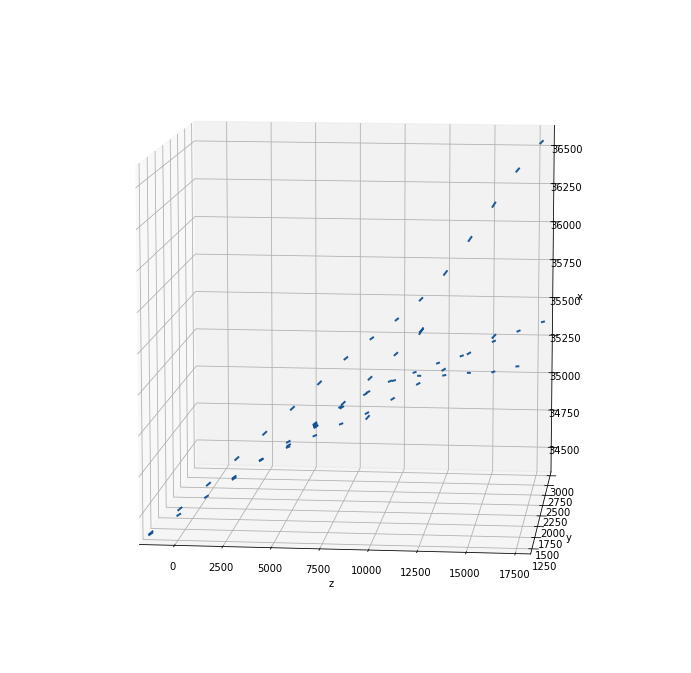

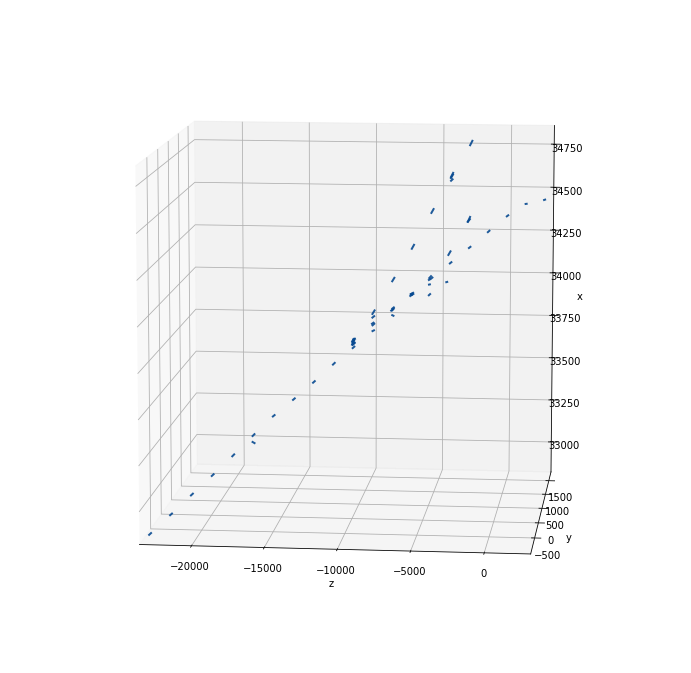

In [95]:
plot_graphx((clusterized_bricks[0]['clusters'][9]))
plot_graphx((clusterized_bricks[0]['clusters'][10]))

In [32]:
NUM_SHOWERS_IN_BRICK

150


 40%|███▉      | 33674/84794 [06:11<09:23, 90.74it/s]

In [33]:
with open('../data/opera/clusterized_bricks_{}.pickle'.format(NUM_SHOWERS_IN_BRICK), 'wb') as f:
    pickle.dump(clusterized_bricks, f, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
len(clusterized_bricks)

29